In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates

import json
import tkp.db
import tkp.config
import logging
import csv
import time
import sys

import itertools
import pylab
import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
import datetime
import os
import glob
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.wcs import WCS


import numbers
import math
import scipy
from scipy.stats import norm
from scipy.stats import sem
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import interpolate, signal


import pymc3 as pm
from scipy.stats import norm

from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

%matplotlib inline

logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def num_err(num, err, n=1):
    '''Return number rounded based on error'''
    return np.around(num,int(-(np.floor(np.log10(nsf(err,n=n)))))), nsf(err,n=n)

def clip(data, sigma=3):
    """Remove all values above a threshold from the array.
    Uses iterative clipping at sigma value until nothing more is getting clipped.
    Args:
        data: a numpy array
    """
    data = data[np.isfinite(data)]
    raveled = data.ravel()
    median = np.median(raveled)
    std = np.nanstd(raveled)
    newdata = raveled[np.abs(raveled-median) <= sigma*std]
    if len(newdata) and len(newdata) != len(raveled):
        return clip(newdata, sigma)
    else:
        return newdata

def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skewnorm(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)


def delta(shape):
    return (shape/pm.math.sqrt(1.0+shape**2.))


def muz(shape):
    return pm.math.sqrt(2./np.pi)*delta(shape) 

def skewness(shape):
    return (4.- np.pi)/2. * ((delta(shape)*pm.math.sqrt(2./np.pi))**3.)/(1.0-(2.0*delta(shape)**2.)/np.pi)**(3./2.)

def sigmaz(shape):
    return np.sqrt(1.-muz(shape)**2.)


def skew_mode(shape):
    return pm.math.sqrt(2.0/np.pi)*delta(shape) - \
        skewness(shape) * pm.math.sqrt(1.0 - (pm.math.sqrt(2.0/np.pi)*delta(shape))**2 )/2.0 - \
        (pm.math.sgn(shape) / 2.0) *( pm.math.exp (-(2.0*np.pi)/pm.math.abs_(shape)))


def sk_mode(loc,scale,shape):
    return loc + skew_mode(shape) * scale

def fit_lightcurve(y, draws=500,chains=4, njobs=4):
    with pm.Model() as model:

        (mu, sigma) = norm.fit(y)

        loc = pm.Normal("loc",mu, 20)
        scale = pm.HalfNormal("scale", sigma)
        skew = pm.Normal("skew", 0, 5)
        mode = pm.Deterministic("mode",sk_mode(loc,scale,skew))
        _y = pm.SkewNormal("y_dist",mu=loc, sd=scale,alpha=skew, observed=y)
        trace = pm.sample(draws=draws, chains=chains, njobs=njobs)
    mode = pm.summary(trace)[pm.summary(trace).index == "mode"]["mean"].values[0]
    mode_err = pm.summary(trace)[pm.summary(trace).index == "mode"]["sd"].values[0]
        
    return mode, mode_err

def distSquared(p0, p1):
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 3.0:
        return np.where(distance == np.min(distance))[0]
    else:
        return None
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def retrieve_source(full_data, run_id):
    source_df = full_data[(full_data.runcatid == run_id)]
    
#     source_df = source_df.groupby('taustart_ts', as_index=False)
    source_df.set_index(source_df.taustart_ts, inplace=True)
    return source_df.sort_index()


def plot_lightcurve(full_data, run_id, ion_sub=False, roll_len = 1*60, roll_type = 'triang', stdout=True):

    source_df = full_data[(full_data.runcatid == run_id)]
    if stdout:
        print source_df.wm_ra.iloc[0], source_df.wm_decl.iloc[0]

    pd.to_datetime(source_df.taustart_ts)
    source_df = source_df.groupby('taustart_ts', as_index=False).mean()
    source_df.set_index(source_df.taustart_ts, inplace=True)

    if ion_sub:
        rolling = source_df.f_int.rolling(roll_len, win_type=roll_type)
        source_df.f_int = source_df.f_int-rolling.mean()


    plt.rcParams['font.size']=16
    plt.rcParams['axes.labelsize']='large'
    plt.rcParams['axes.titlesize']='large'
    pylab.rcParams['legend.loc'] = 'best'

    ylim = [np.nanmean(source_df.f_int)-6.0*np.nanstd(source_df.f_int),
            np.nanmean(source_df.f_int)+10.0*np.nanstd(source_df.f_int)]



    myFmt = mdates.DateFormatter('%H:%M')
    source_df["taustart_ts"] = pd.to_datetime(source_df["taustart_ts"])
    obs_dates = np.unique([100*x.month+x.day for x in source_df["taustart_ts"]])

    n_hours = np.array([]) 
    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        n_hours = np.append(n_hours, len(np.unique(pd.DatetimeIndex(source_df["taustart_ts"][index]).hour)))
    hour_ratio = [i/n_hours.sum() for i in n_hours ]
    gs_ratio = np.append((hour_ratio)/min(hour_ratio),1)

    gs = gridspec.GridSpec(1, len(obs_dates)+1, width_ratios=gs_ratio) 

    figcount = 0
    figure = plt.figure(figsize=(4*len(obs_dates),6))

    for i in obs_dates:
        index = (100*pd.DatetimeIndex(source_df["taustart_ts"]).month+pd.DatetimeIndex(source_df["taustart_ts"]).day == i)# & (source_df.extract_type == 0)
        ax = plt.subplot(gs[figcount])
        ax.locator_params(nticks=6)
        ax.errorbar(source_df["taustart_ts"].values[index],
                    source_df["f_int"].values[index],
                    yerr=source_df["f_int_err"].values[index],
                    fmt=".",c="#1f77b4",ecolor="#ff7f0e")

        if figcount > 0:
            ax.set_yticks([])
        if figcount ==0:
            plt.ylabel("Flux [Jy]")
            ax.yaxis.set_ticks_position('left')
        if stdout:
            print source_df["taustart_ts"].values[index][0]
        plt.annotate("{}-{}".format(pd.DatetimeIndex(source_df["taustart_ts"].values[index]).day[0],
                                    pd.DatetimeIndex(source_df["taustart_ts"].values[index]).month[0]),
                                    xy=(0.95,0.95), xycoords='axes fraction',
                                    horizontalalignment='right', verticalalignment='top',fontsize=16)

        plt.xticks(rotation=90)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(myFmt)
        figcount+=1

    hist_index = np.isfinite(source_df["f_int"]) #& (source_df.extract_type == 0)
    plt.subplot(gs[figcount])
    (mu, sigma) = norm.fit(source_df["f_int"].iloc[hist_index].values)
    n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
                                   bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")
    y = mlab.normpdf( bins, mu, sigma)
    if stdout:
        print "Gaus fit: mu {}, sigma {}".format(round(mu,3),round(sigma,3))
    
    l = plt.plot(y,bins,'r--', linewidth=2)
    plt.annotate("Total N:\n{}".format(len(source_df["f_int"].values[hist_index])),
                                xy=(0.95,0.95), xycoords='axes fraction',
                                horizontalalignment='right', verticalalignment='top',fontsize=16)
    plt.yticks([])
    plt.ylim(ylim)
    plt.xticks(rotation=90)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    return figure





In [3]:
aart = pd.read_csv("/home/kuiack/AARTFAAC_catalogue.csv")


#### Load all data


In [4]:

# /home/kuiack/TR_20160905_flux.csv

all_data_name = "/home/kuiack/TR_20160905_flux.csv"
data = pd.read_csv(all_data_name, infer_datetime_format=True)
data.taustart_ts = pd.to_datetime(data.taustart_ts)
dbname = "tr_20160905"

#### Source target

In [ ]:
[1, 2,235, 248, 241, 221]

In [16]:
# TR-1 Galaxy - 1 231
# target_ra = 273.5
# target_decl = 26.5

# TR-2 Galaxy - 2  245
# target_ra = 278.77
# target_decl = 32.7

# nearby QSO - 235
# target_ra = 275.31
# target_decl = 22.85

# nearby radio source - 248
# target_ra = 280.01
# target_decl = 24.04

# nearby QSO - 241
# target_ra = 278.21
# target_decl = 28.56

# nearby QSO - 221
target_ra = 267.94
target_decl = 29.84

# herc - 196 197
# target_ra = 252.77
# target_decl = 5.0

# 3c380 4 240
target_ra = 277.48
target_decl = 48.65


radius = 1

IDS = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
                     (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) ].runcatid )

print IDS

[  4 240]


In [7]:
IDS = []
aart_flux = []

for i in range(len(aart)):


    target_ra = aart.iloc[i].ra
    target_decl = aart.iloc[i].decl

# target_ra = 311.
# target_decl = 50.


# target_ra = 148.56
# target_decl = 7.66

    radius = 0.5



# IDS = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
#                      (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) &
#                      (data.extract_type == 2)].runcatid )
    ID = np.unique(data[(data.ra > target_ra-radius) &  (data.ra < target_ra+radius) &
                     (data.decl > target_decl-radius) &  (data.decl < target_decl+radius) ].runcatid )
    try:
        print ID[0]
        IDS.append(ID[0])
        aart_flux.append(aart.iloc[i].f_int)
    except IndexError:
        continue 

45
2
159
152
187
126
268
80
79
196
129
3
317
112
168
174
304
203
110
309
144
5
294
55
80
207
9
139
148
250
135
115
122
127
300
134
130
4
157
284
118
253
307


### Plot individual source lightcurves 

In [ ]:
%matplotlib notebook



all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


fig_n =0

for _ID in IDS: # np.unique(data.runcatid):

    source_df = retrieve_source(data, _ID)
    n_c = 0
    for freq in all_freq:


        plt.figure(fig_n,figsize=(10,6))

        plt.errorbar(source_df.taustart_ts[(source_df.freq_eff == freq)].values,
                     source_df.f_int[(source_df.freq_eff == freq) ].values,
                     yerr = source_df.f_int_err[(source_df.freq_eff == freq) ].values,
                     fmt="-", color=colors[::-1][n_c],ecolor="white", label="{} MHz".format(round(freq/1e6,1)))

        n_c+=1

    
    

    plt.title("AARTFAAC flux: {} Jy \nID: {}, {} {} ".format(aart_flux[fig_n],_ID,
                                                            round(np.nanmean(source_df.ra),2),
                                                            round(np.nanmean(source_df.decl),2) ))
    plt.ylabel("Integrated flux [Jy]")
    plt.legend(ncol=2)


    plt.xlabel("Time [UTC]")
    plt.show()
    fig_n +=1

### Measure Burst DM from delay 

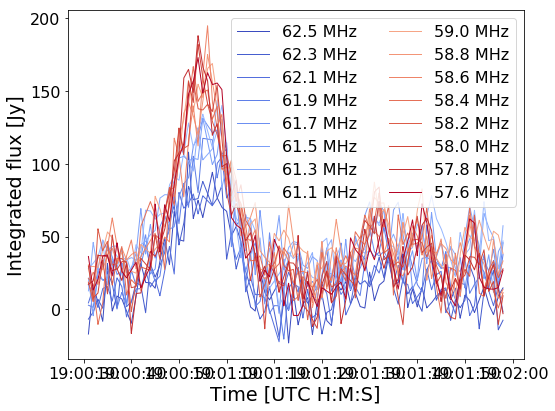

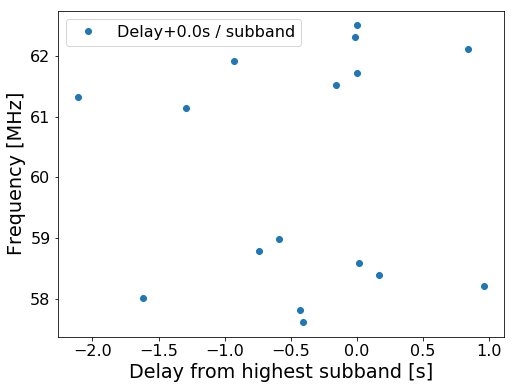

In [128]:
n_c = 0
fig_n = 0
step=0.01
delay = []


# burst = data[(data.runcatid == 1) &
#             (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=18,minute=50,second=0)) & 
#             (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=18,minute=51,second=10))]

burst = data[(data.runcatid == 2) &
            (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=30)) & 
            (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
burst.set_index(burst.taustart_ts, inplace=True)
burst = burst.sort_index()
burst["timestep"] = [x.timestamp() for x in burst.taustart_ts]




all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


start = []
end = [] 
for freq in all_freq[::-1]:
    start.append(np.min(burst.timestep[(burst.freq_eff == freq)].values))
    end.append(np.max(burst.timestep[(burst.freq_eff == freq)].values))
    
xnew = np.arange(np.max(start),np.min(end), step)



#     plt.subplot(211)
n_c = 0
fig_n = 0
step=0.01
delay = []

_source_flux = burst.f_int[(burst.freq_eff == all_freq[-1]) ].values


fa = interpolate.interp1d(burst.timestep[(burst.freq_eff == all_freq[-1])].values, 
                          _source_flux)
roll_n = 0
i = 0

roll = i*np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.], dtype=int)


fig_n =0
for freq in all_freq[::-1]:
    
    _source_flux = burst.f_int[(burst.freq_eff == freq) ].values


    
    fb = interpolate.interp1d(burst.timestep[(burst.freq_eff == freq)].values, 
                              _source_flux)    


    plt.figure(333,figsize=(8,6))
    ax = plt.subplot(111)

    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]
    ax.errorbar(xaxis,np.roll(fb(xnew),roll[roll_n]), lw=1,
                 color=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))
   


    delay.append(np.argmax(signal.correlate(fa(xnew),fa(xnew), mode="same")) \
                 - np.argmax(signal.correlate(fa(xnew),np.roll(fb(xnew),roll[roll_n]), mode="same"))  )
 
    roll_n += 1


    n_c+=1

myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
    
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)

plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.savefig("/home/kuiack/TR_1.png")


plt.figure(figsize=(8,6))
plt.plot(np.array(delay)*step,all_freq[::-1]/1e6,"o", label="Delay+{}s / subband".format(step*i))
plt.ylabel("Frequency [MHz]")
plt.xlabel("Delay from highest subband [s]")
plt.legend()



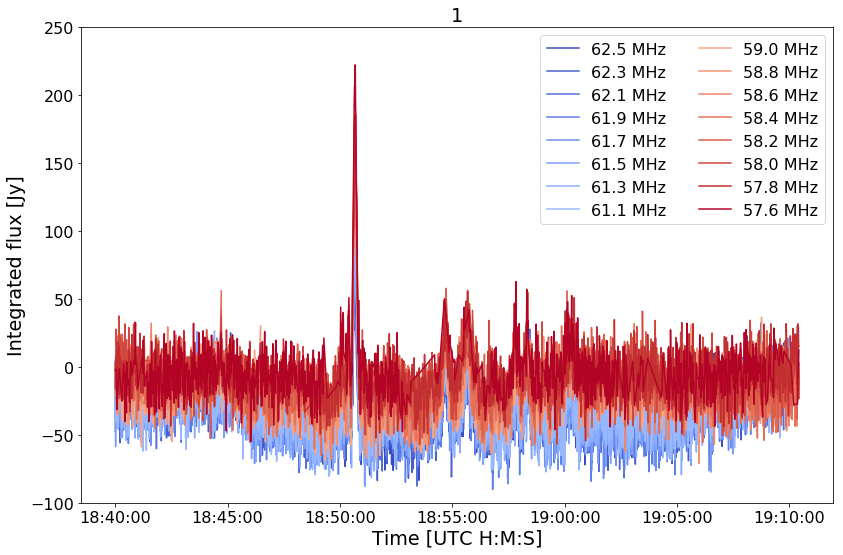

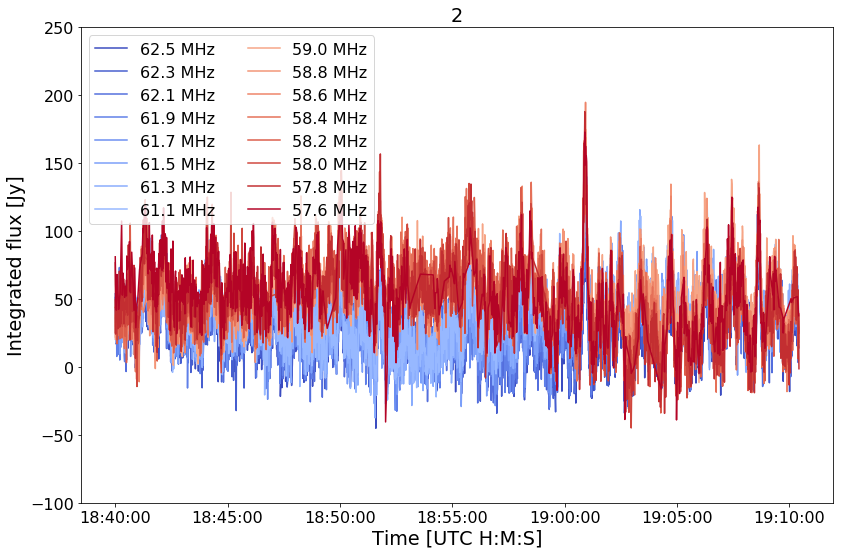

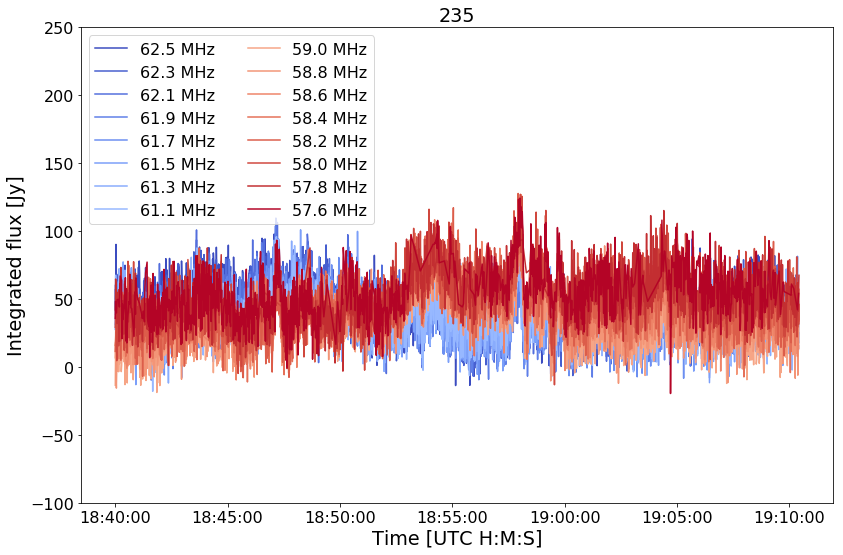

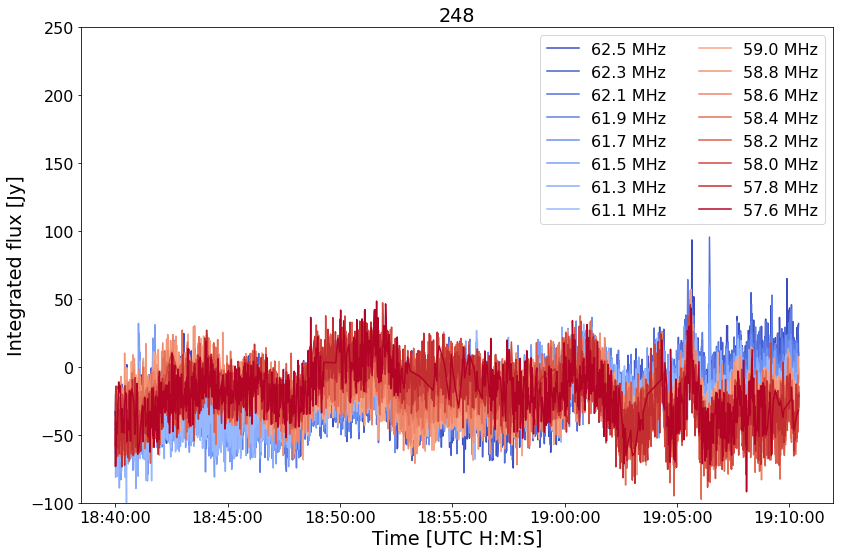

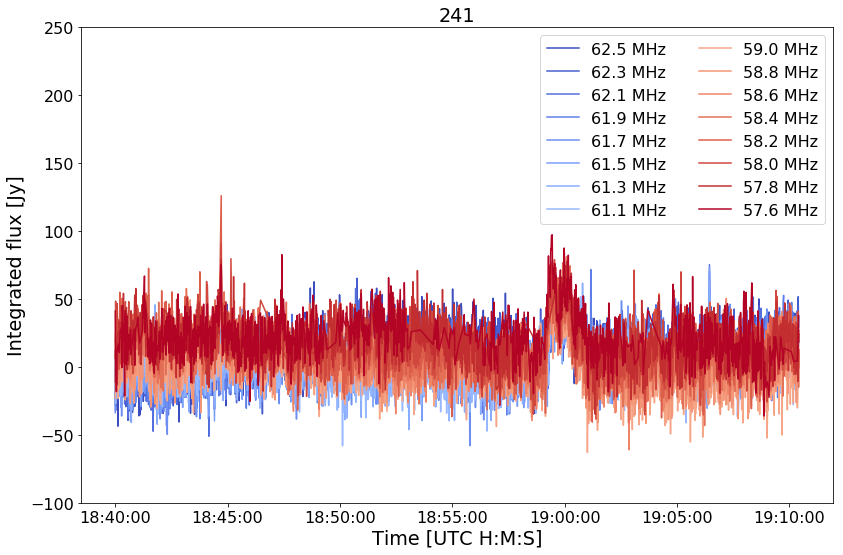

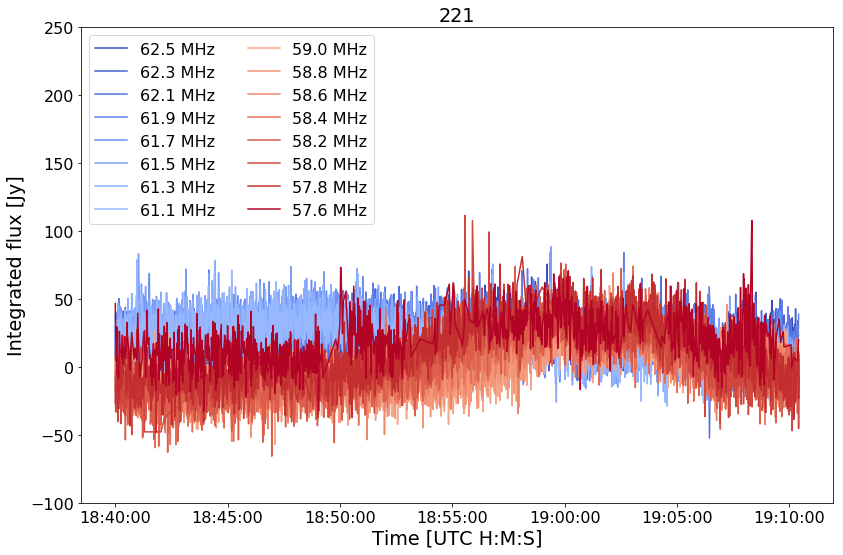

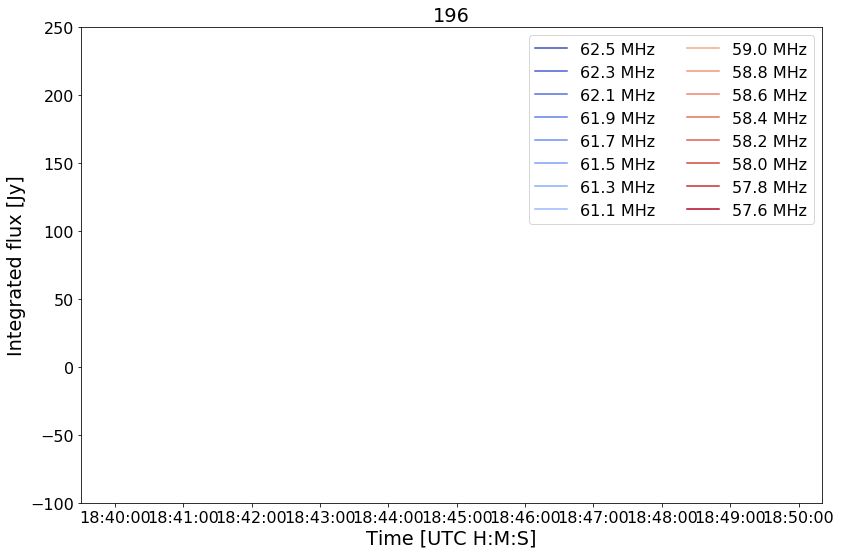

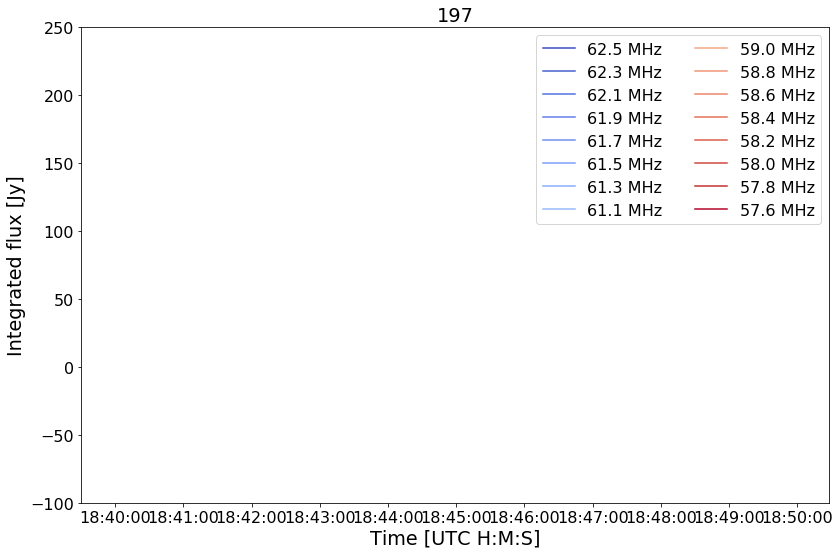

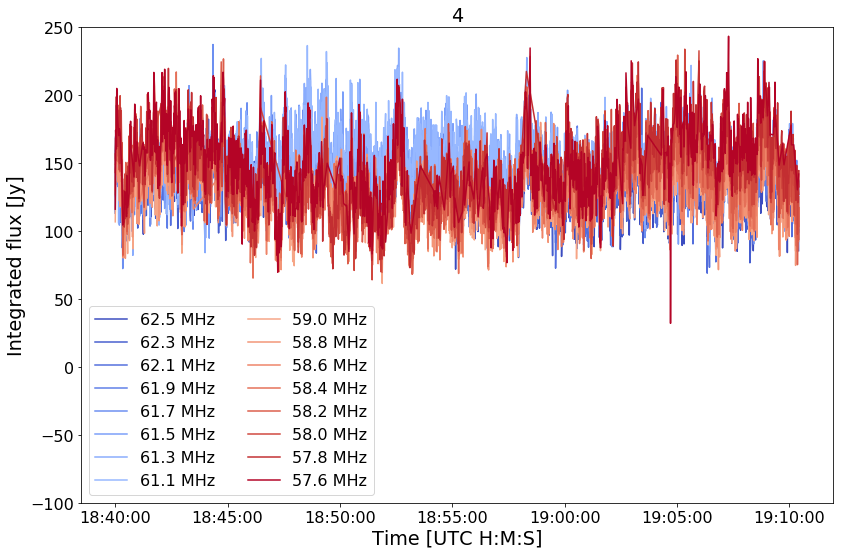

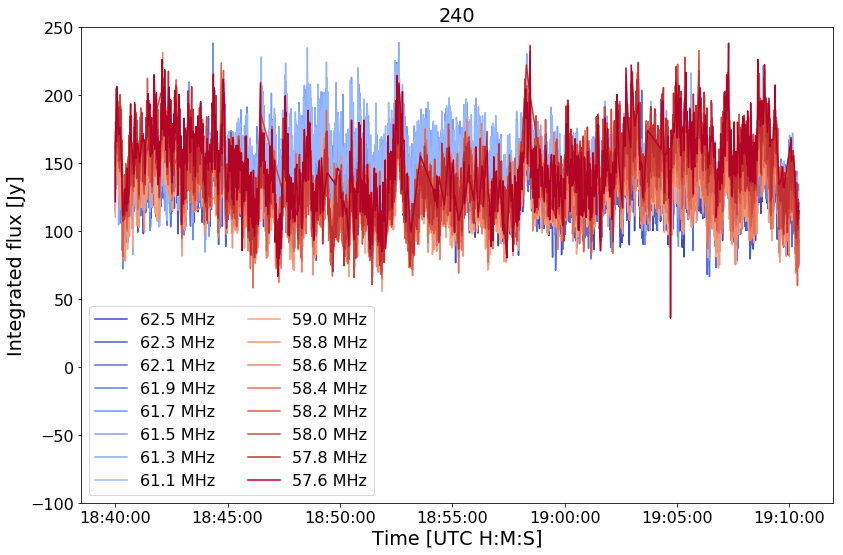

In [9]:
%matplotlib inline
n_c = 0 





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)


for _ID in [1, 2,235, 248, 241, 221, 196, 197, 4, 240]:
    n_c = 0 
    plt.figure(figsize=(12,8))
    for freq in all_freq[::-1]:

        ax = plt.subplot(111)
        burst = data[(data.runcatid == _ID) & (data.freq_eff == freq) ]# &
    #                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
    #                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
        burst.set_index(burst.taustart_ts, inplace=True)
        burst = burst.sort_index()


        xnew = [x.timestamp() for x in burst.taustart_ts]
        xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

        ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

        n_c += 1


    myFmt = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylim([-100,250])
    plt.ylabel("Integrated flux [Jy]")
    plt.legend(ncol=2)
    plt.title(_ID)
    plt.xlabel("Time [UTC H:M:S]")
    plt.tight_layout()
plt.show()

# plt.savefig("/home/kuiack/TR-2_burstlightcurve.png")

# get TR from database 

In [7]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'
query_loglevel = logging.WARNING 



In [8]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients


dbname = "TR_20190101"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """SELECT ex.f_int, ex.f_int_err,ex.f_peak, 
    ex.det_sigma, extract_type, 
    ex.ra, 
    ex.decl, 
    im.band, 
    im.taustart_ts,
    im.freq_eff
    FROM extractedsource ex, image im 
    WHERE ex.id IN ( select xtrsrc FROM assocxtrsource WHERE runcat =  2227) 
    AND ex.image = im.id;
    """
# 89 - reverse DM

TR_data = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

INFO:tkp.db.database:Database config: postgresql://mkuiack@ads001:5432/TR_20190101
INFO:tkp.db.database:connecting to database...


database name:  TR_20190101
Found 22520 new sources


<IPython.core.display.Javascript object>


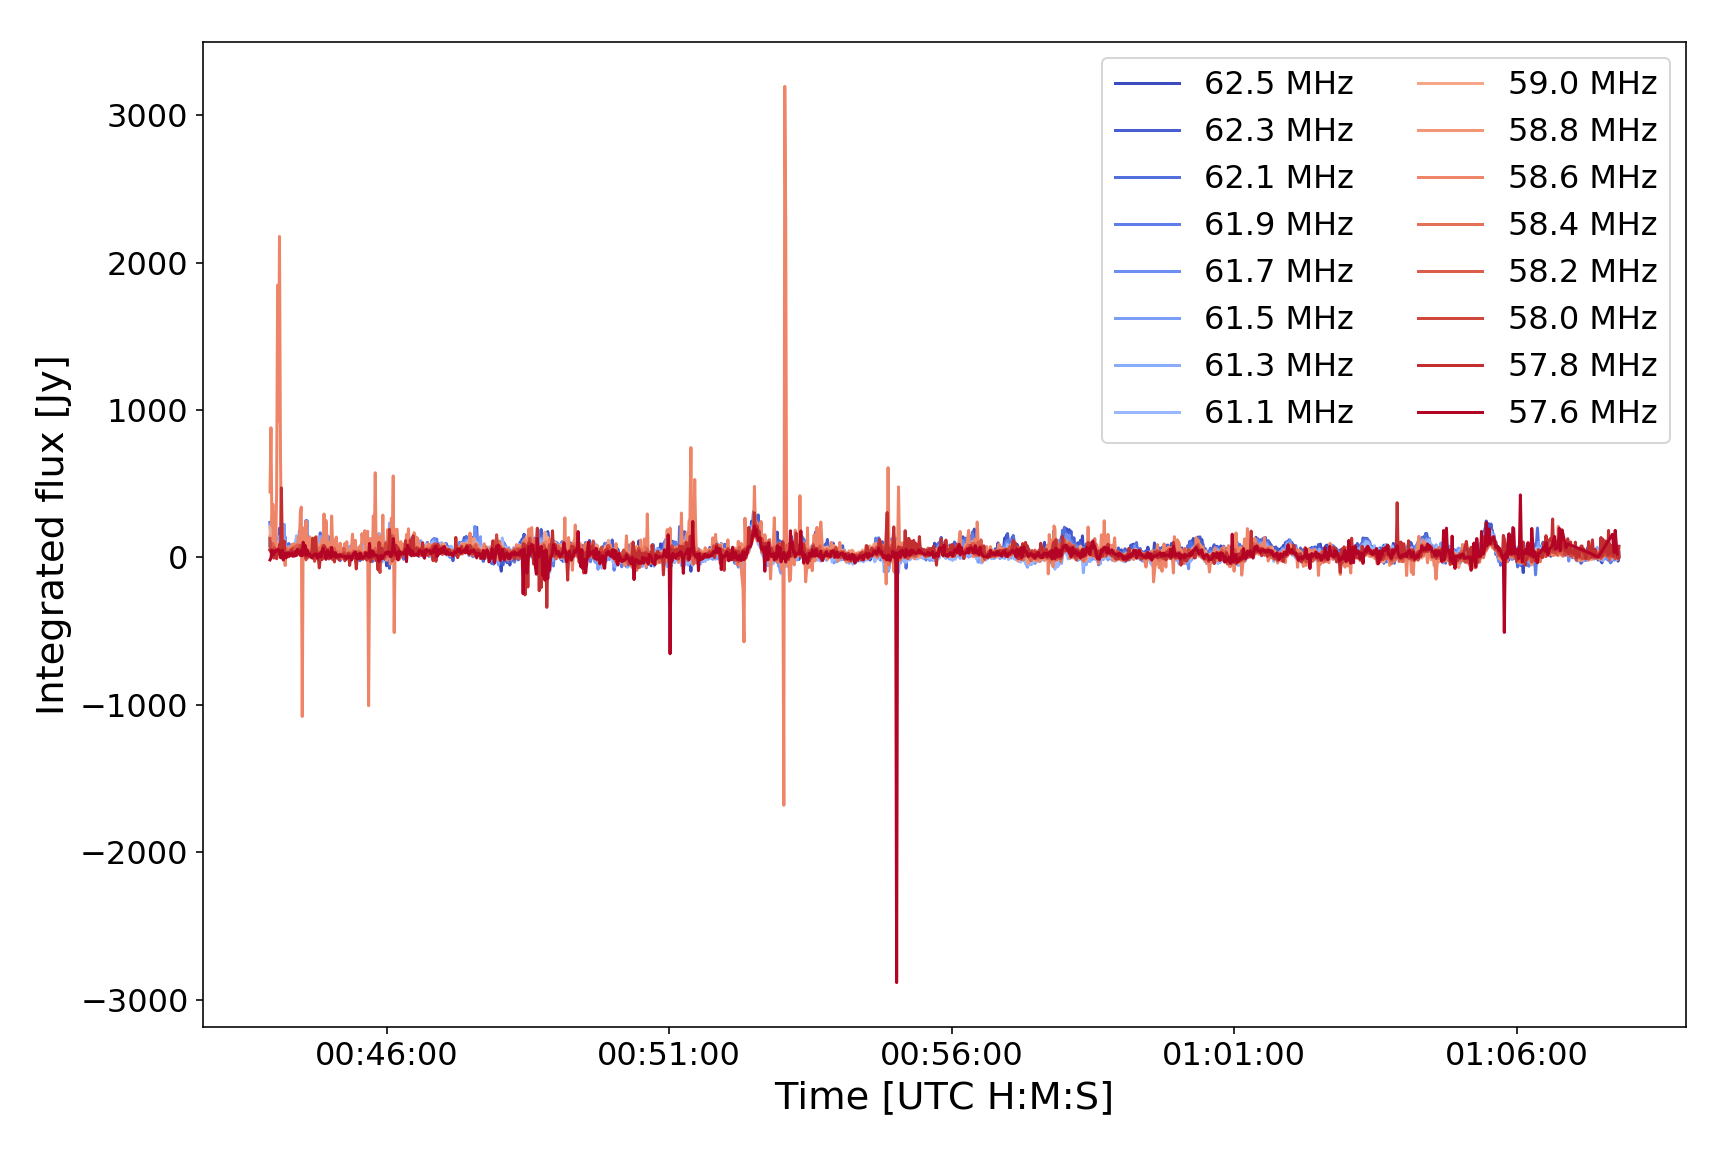

In [9]:
%matplotlib notebook
n_c = 0 





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(TR_data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)



n_c = 0 
plt.figure(figsize=(12,8))
for freq in all_freq[::-1]:

    ax = plt.subplot(111)
    burst = TR_data[(TR_data.freq_eff == freq)]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()


    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    n_c += 1


myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
#     ax.set_ylim([-100,200])
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)
# plt.title(_ID)
plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


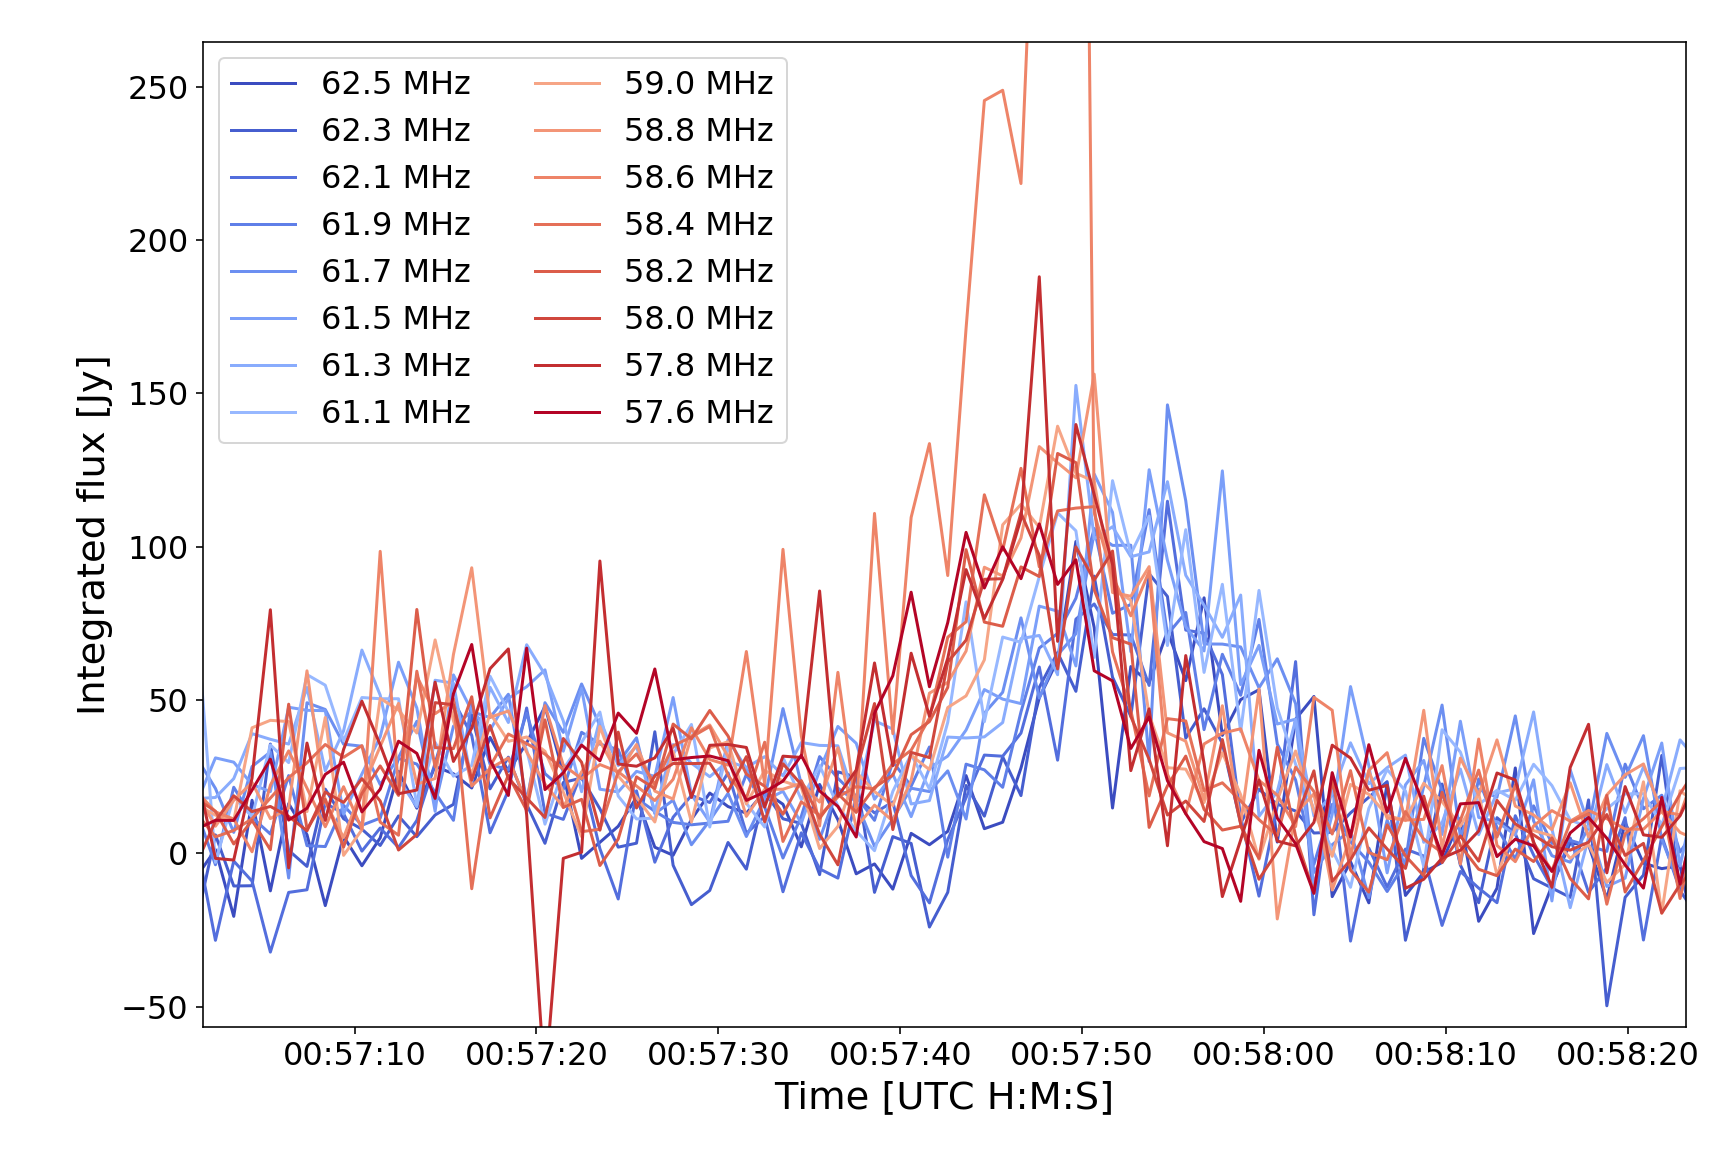

In [21]:
%matplotlib notebook
n_c = 0 





plt.rcParams['font.size']=16
plt.rcParams['axes.labelsize']='large'
plt.rcParams['axes.titlesize']='large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False

all_freq = np.unique(TR_data.freq_eff)
scaled_all_freq = (all_freq - all_freq.min()) / all_freq.ptp()
colors = plt.cm.coolwarm(scaled_all_freq)



n_c = 0 
plt.figure(figsize=(12,8))
for freq in all_freq[::-1]:

    ax = plt.subplot(111)
    burst = TR_data[(TR_data.freq_eff == freq)]# &
#                   (data.taustart_ts > datetime.datetime(year=2016,day=5, month=9, hour=19,minute=0,second=0)) & 
#                   (data.taustart_ts < datetime.datetime(year=2016,day=5, month=9, hour=19,minute=2,second=0))]
    burst.set_index(burst.taustart_ts, inplace=True)
    burst = burst.sort_index()


    xnew = [x.timestamp() for x in burst.taustart_ts]
    xaxis = [datetime.datetime.utcfromtimestamp(x) for x in xnew]

    ax.plot(xaxis, burst.f_int , c=colors[n_c], label="{} MHz".format(round(freq/1e6,1)))

    n_c += 1


myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
#     ax.set_ylim([-100,200])
plt.ylabel("Integrated flux [Jy]")
plt.legend(ncol=2)
# plt.title(_ID)
plt.xlabel("Time [UTC H:M:S]")
plt.tight_layout()
plt.show()